In [1]:
!pip install resampy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install np_utils

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, f1_score, log_loss


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score


import seaborn as sns

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [6]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [7]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [8]:
len(df)

3480

In [9]:
def get_duration(file_name):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [10]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [01:28, 39.15it/s]


In [11]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [12]:
len(sorted_df)

3471

In [13]:
df_class1 = sorted_df[sorted_df['class'] == 'IRoar']
df_class2 = sorted_df[sorted_df['class'] == 'Roar']
df_class3 = sorted_df[sorted_df['class'] == 'Grunt']

# Randomly select 900 samples from each class
sample_size = 900
df_class1_balanced = df_class1.sample(n=sample_size, random_state=42)
df_class2_balanced = df_class2.sample(n=sample_size, random_state=42)
df_class3_balanced = df_class3.sample(n=sample_size, random_state=42)

# Combine the balanced DataFrames into a single DataFrame
df_balanced = pd.concat([df_class1_balanced, df_class2_balanced, df_class3_balanced])

# Shuffle the combined DataFrame to mix the samples from all three classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [15]:
appended = []
for i in range(1,4):
    appended.append(df_balanced[df_balanced.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Roar,IRoar,Grunt
0,fold1,305,301,298
1,fold2,297,299,304
2,fold3,298,300,298


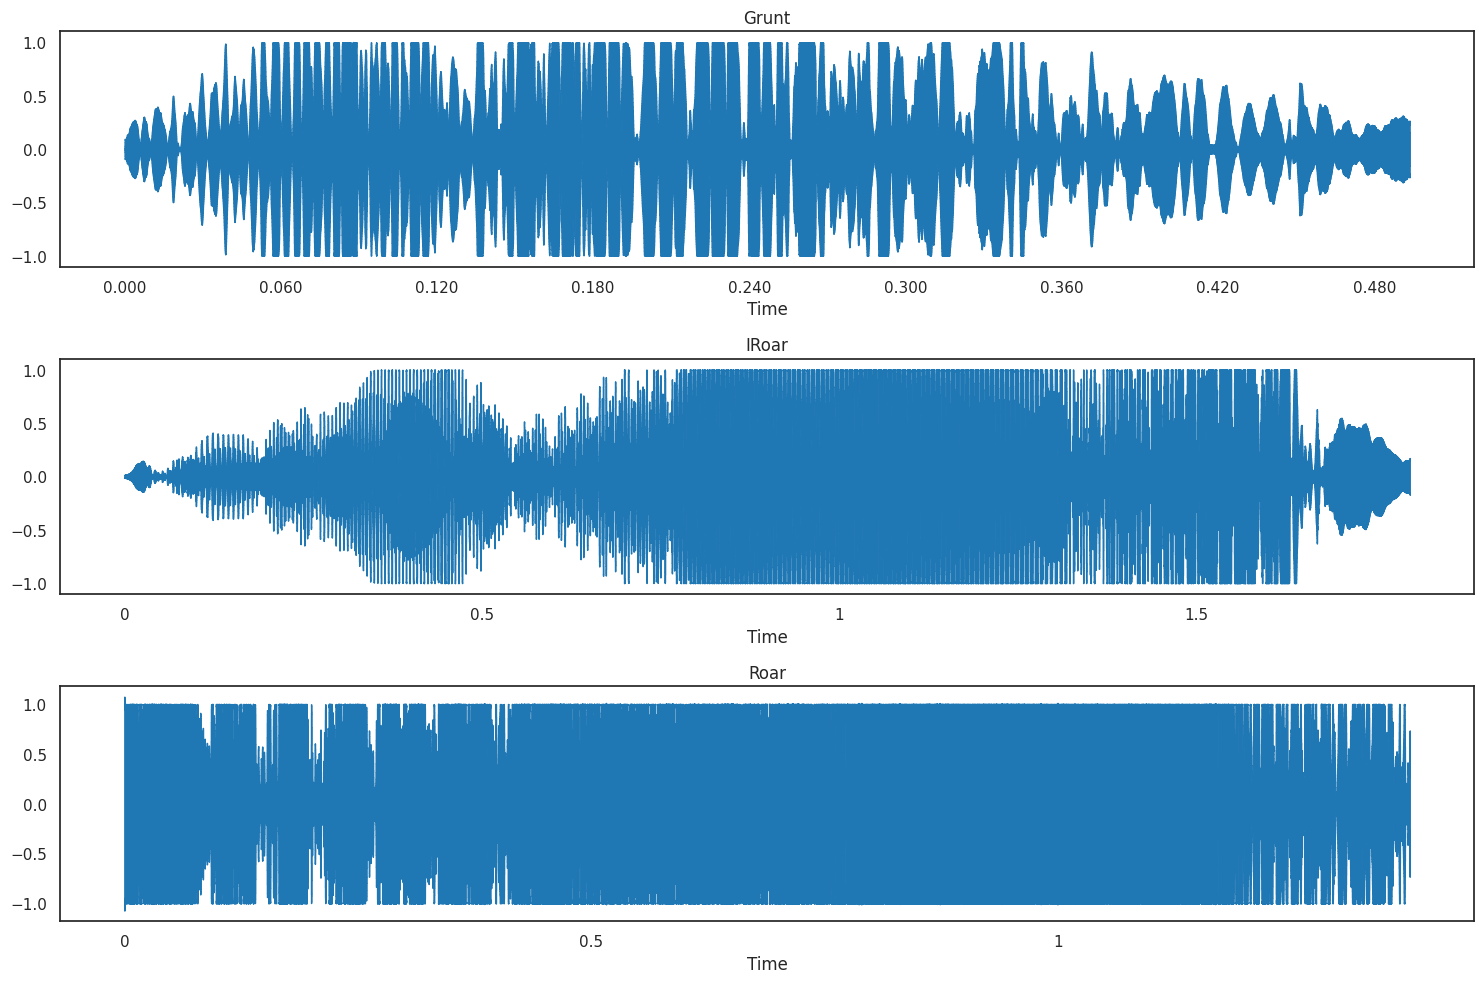

In [16]:
# Randomly select one sample of each class
random_samples = df_balanced.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

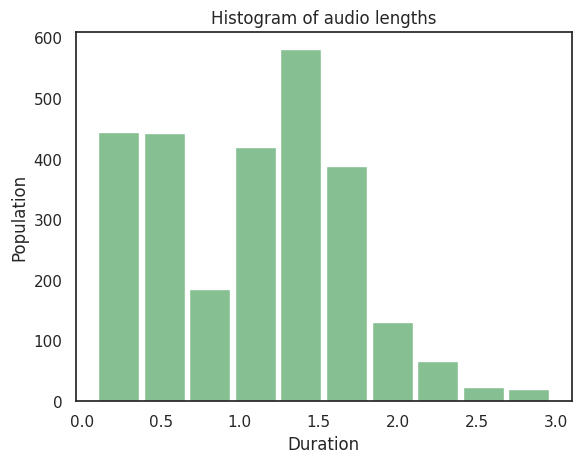

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 140
Lower than 2 but greater than 1 seconds: 1447
Lower than 1 seconds: 1113


In [17]:
plt.hist(df_balanced['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = df_balanced['duration'][(df_balanced['duration'] > 3)].count()
gt_2sec = df_balanced['duration'][(df_balanced['duration'] > 2) & (df_balanced['duration'] < 3)].count()
lt_2sec = df_balanced['duration'][(df_balanced['duration'] > 1) & (df_balanced['duration'] < 2)].count()
lt_1sec = df_balanced['duration'][df_balanced['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [18]:
df_balanced.head()

,fs_id,slice_file_name,classID,fold,class,filepath,duration
0,roar_276,roar_276.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_2...,2.337959
1,roar_76,roar_76.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_7...,1.623946
2,roar_314,roar_314.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_3...,1.236054
3,iroar_628,iroar_628.wav,1,2,IRoar,/content/drive/MyDrive/ThesisData/File2/iroar_...,1.789161
4,roar_784,roar_784.wav,0,3,Roar,/content/drive/MyDrive/ThesisData/File3/roar_7...,1.567619


In [19]:
df_balanced.groupby(['class'])['duration'].max()

class
Grunt    1.696372
IRoar    2.971837
Roar     2.877506
Name: duration, dtype: float64

In [20]:
df_balanced.groupby(['class'])['duration'].min()

class
Grunt    0.090658
IRoar    0.616236
Roar     0.210476
Name: duration, dtype: float64

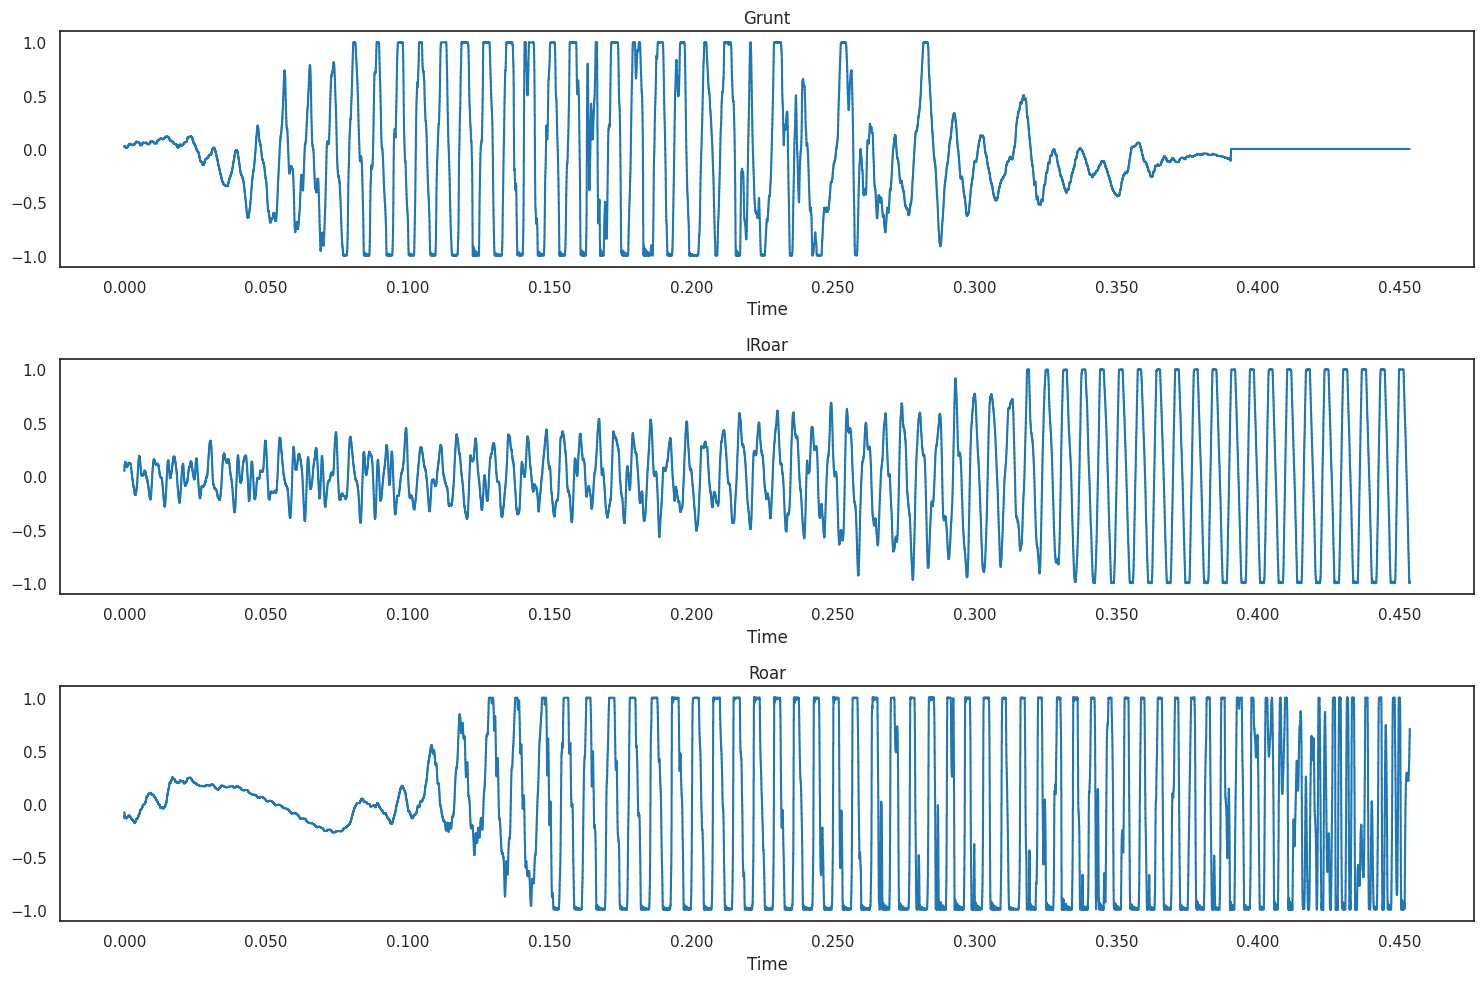

In [21]:
start = 0
end = 0
max_audio_duration = 3

# Randomly select one sample of each class
random_samples = df_balanced.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()


# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    y_trimmed, _ = librosa.effects.trim(audio_file)

    # Pad the audio to the maximum duration of 3 seconds
    max_samples = int(max_audio_duration * sample_rate)
    y_trimmed = np.pad(y_trimmed, (0, max_samples - len(y_trimmed)), mode='constant')

    if labels[index] == "IRoar":
      start = 0
      end= 10000
    elif labels[index] == "Roar":
      start = 0
      end= 10000
    elif labels[index] == "Grunt":
      start = 0
      end= 10000
    librosa.display.waveshow(y=y_trimmed[start:end], sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

In [22]:
# Feature extraction using librosa

data = []
labels = []
max_audio_duration = 3

start = 0
end = 0

path='/content/drive/MyDrive/ThesisData/File'
for i in tqdm(range(len(df_balanced))):
    fold_no=str(df_balanced.iloc[i]["fold"])
    file=df_balanced.iloc[i]["slice_file_name"]
    label=df_balanced.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename, res_type='kaiser_fast')
    #trim the audio file
    y_trimmed, _ = librosa.effects.trim(y)

    # Pad the audio to the maximum duration of 3 seconds
    max_samples = int(max_audio_duration * sr)
    y_trimmed = np.pad(y_trimmed, (0, max_samples - len(y)), mode='constant')

    if df_balanced.iloc[i]["class"] == "IRoar":
      start = 0
      end= 10000
    elif df_balanced.iloc[i]["class"] == "Roar":
      start = 0
      end= 10000
    elif df_balanced.iloc[i]["class"] == "Grunt":
      start = 0
      end= 10000
    mfccs_mean = np.mean(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=13).T,axis=0)
    mfccs_std = np.std(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=13).T,axis=0)

    # Extract RMSE (temporal patterns)
    rmse_mean = np.mean(librosa.feature.rms(y=y_trimmed[start:end]))
    rmse_std = np.std(librosa.feature.rms(y=y_trimmed[start:end]))

    features = np.concatenate((mfccs_mean, mfccs_std, [rmse_mean, rmse_std]))

    data.append(features)
    labels.append(label)

100%|██████████| 2700/2700 [02:41<00:00, 16.70it/s]


In [23]:
data=np.array(data)
labels=np.array(labels)

In [24]:
data.shape, labels.shape

((2700, 28), (2700,))

In [25]:
# Shuffle the data
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [26]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(labels)

In [27]:
from sklearn.utils.class_weight import compute_class_weight

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results for each fold
training_accuracies = []
validation_accuracies = []
training_losses = []
validation_losses = []
fold_log_losses = []
confusion_matrices = []

In [31]:
# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(data, y_encoded):
    # Split the data into train and test sets for this fold
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Calculate class weights to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Data Preprocessing
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the multi-class SVM classifier
    C_value = 1.0  # You can experiment with different C values

    svm_classifier = SVC(kernel='rbf', C=C_value, class_weight='balanced', probability=True, random_state=42)
    svm_classifier.fit(X_train, y_train)

    # Make predictions
    predictions = svm_classifier.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predictions)
    confusion_matrices.append(cm)

    # Training accuracy
    train_predictions = svm_classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    training_accuracies.append(train_accuracy)

    # Training loss
    train_prob = svm_classifier.predict_proba(X_train)
    train_loss = log_loss(y_train, train_prob)
    training_losses.append(train_loss)

    # Validation accuracy
    val_accuracy = accuracy_score(y_test, predictions)
    validation_accuracies.append(val_accuracy)

    # Validation loss
    prob = svm_classifier.predict_proba(X_test)  # Predicted probabilities
    val_loss = log_loss(y_test, prob)
    validation_losses.append(val_loss)

    # Mean log loss for this fold
    fold_loss = log_loss(y_test, prob)
    fold_log_losses.append(fold_loss)

# Calculate the mean training accuracy, mean validation accuracy, mean training loss, mean validation loss, and mean log loss over all folds
mean_train_accuracy = np.mean(training_accuracies)
mean_val_accuracy = np.mean(validation_accuracies)
mean_train_loss = np.mean(training_losses)
mean_val_loss = np.mean(validation_losses)
mean_fold_log_loss = np.mean(fold_log_losses)

print("Training accuracies for each fold:", training_accuracies)
print("Mean Training Accuracy:", mean_train_accuracy)

print("Validation accuracies for each fold:", validation_accuracies)
print("Mean Validation Accuracy:", mean_val_accuracy)

print("Training losses for each fold:", training_losses)
print("Mean Training Loss:", mean_train_loss)

print("Validation losses for each fold:", validation_losses)
print("Mean Validation Loss:", mean_val_loss)

print("Log Loss for each fold:", fold_log_losses)
print("Mean Log Loss:", mean_fold_log_loss)

# Print confusion matrices
for i, cm in enumerate(confusion_matrices):
    print(f"Fold {i + 1} - Confusion Matrix:\n", cm)

Training accuracies for each fold: [0.9087962962962963, 0.9175925925925926, 0.9120370370370371, 0.913425925925926, 0.912962962962963]
Mean Training Accuracy: 0.912962962962963
Validation accuracies for each fold: [0.8944444444444445, 0.8740740740740741, 0.8888888888888888, 0.8722222222222222, 0.8814814814814815]
Mean Validation Accuracy: 0.8822222222222222
Training losses for each fold: [0.24371342676716287, 0.23360811560608122, 0.23634212097913793, 0.23390972253033213, 0.2308412343753202]
Mean Training Loss: 0.23568292405160687
Validation losses for each fold: [0.28987440302242595, 0.32991546360318197, 0.3001318945577442, 0.3228975647905008, 0.31685630894730055]
Mean Validation Loss: 0.31193512698423065
Log Loss for each fold: [0.28987440302242595, 0.32991546360318197, 0.3001318945577442, 0.3228975647905008, 0.31685630894730055]
Mean Log Loss: 0.31193512698423065
Fold 1 - Confusion Matrix:
 [[155  15  10]
 [ 23 155   2]
 [  5   2 173]]
Fold 2 - Confusion Matrix:
 [[148  22  10]
 [ 30 

In [32]:
# Plot confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

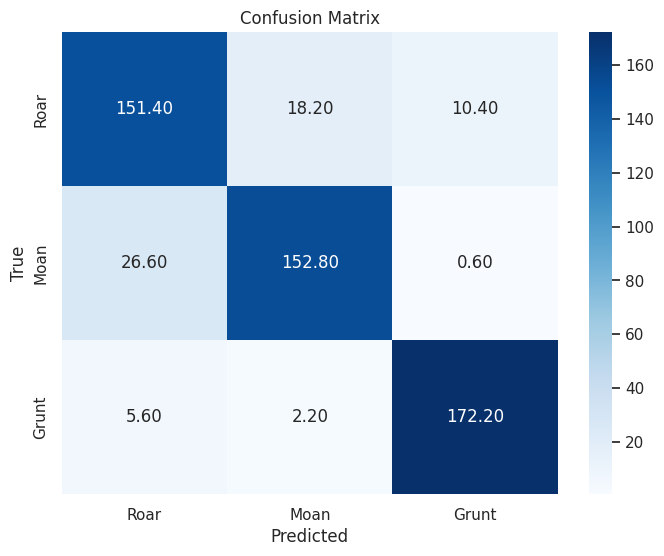

In [33]:
# Calculate the mean confusion matrix over all folds
mean_cm = np.mean(confusion_matrices, axis=0)

# Define class labels (replace with your class labels)
class_labels = [ 'Roar', 'Moan', 'Grunt']

# Plot the mean confusion matrix
plot_confusion_matrix(mean_cm, labels=class_labels)